# Baseline Modeling

In the Modeling phase, it is very tempting to jump right into research and to implement a cutting edge machine learning techniques. In data science, it is important to build a simple baseline first. Often, baseline models deliver 90% of value for 10% of the effort. The beauty of a simple baseline model is that it is often very hard to beat and the cutting edge models will achieve just a marginal improvement over it. 

There are few requirements for a good baseline model:
- Baseline model should be simple (often linear) models. Simple models are less likely to overfit. If you observe that the baseline model is already overfitting, more complex modelling will only kill the performance.
- Baseline model should be interpretable. Explainability will help you to get a better understanding of your data and will show you which direction to go for in signal processing and the feature engineering.

## Data Loading

Import the required libraries to build a simple baseline model.

In [6]:
import sys
import math
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.insert(1, '../src/')
from utils import load_dataset_data
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import plot_confusion_matrix, f1_score, confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score,auc

Load the data using the functions defined earlier.

In [7]:
X_train, y_train, subject_train, X_test, y_test, subject_test = load_dataset_data()

In [8]:
activity_dict={
        1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS', 
        4: 'SITTING', 5: 'STANDING', 6: 'LYING', 
        7: 'STAND_TO_SIT',  8: 'SIT_TO_STAND',  9: 'SIT_TO_LIE', 10: 'LIE_TO_SIT', 
        11: 'STAND_TO_LIE', 12: 'LIE_TO_STAND',
       }

## Linear Baseline Model

For the baseline model, we are using Logistic Regression without regularization. 
Logistic Regression is a simple linear parametric model. We evaluate the model on the train and test as we want to observe if overfitting occurs.

In [9]:
clf = LogisticRegression(random_state=0, solver='newton-cg').fit(X_train, y_train.values.ravel())
y_pred_train = clf.predict(X_train)
y_pred_proba_train = clf.predict_proba(X_train)

y_pred_test = clf.predict(X_test)
y_pred_proba_test = clf.predict_proba(X_test)

We print out a couple of metrics to understand how the model performans on unseen test data. Performance is calculated on both the train and test set to asses whether the model is overfitting or underfitting.

In [10]:
accuracy_score(y_pred_train, y_train), accuracy_score(y_test, y_pred_test)

(0.9924037594953007, 0.9459203036053131)

In [11]:
f1_score(y_pred_train, y_train, average='macro'), f1_score(y_pred_test, y_test, average='macro')

(0.9963710372337595, 0.8598321333292757)

In [12]:
roc_auc_score(y_train, y_pred_proba_train, multi_class="ovr"),roc_auc_score(y_test, y_pred_proba_test, multi_class="ovr")

(0.9999250833769487, 0.9969286770510363)

To better understand in which classes the model is making mistakes, we plot the confusion matrix.

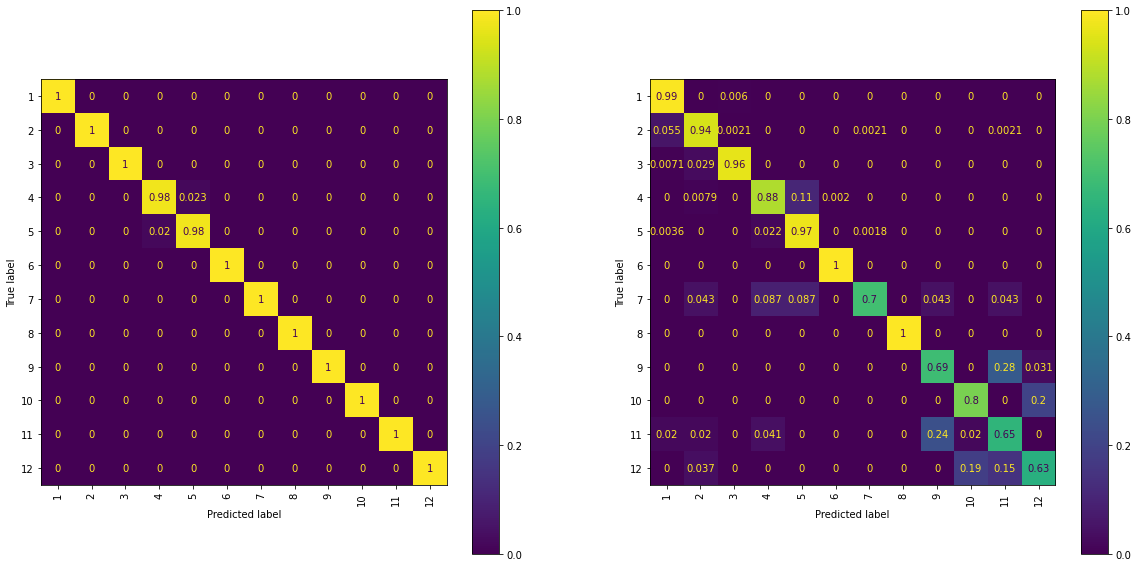

In [13]:
f, ax =plt.subplots(nrows=1, ncols=2, figsize=(20,10))
plot_confusion_matrix(clf, X_train, y_train, normalize='true', xticks_rotation='vertical', ax=ax[0])
plot_confusion_matrix(clf, X_test, y_test, normalize='true', xticks_rotation='vertical', ax=ax[1])

Clearly, there are several areas challenging for the model, some of which can be intuitively interpreted:
- WALKING, WALKING_UPSTAIRS & WALKING_DOWNSTAIRS are often confused. A non-linear model will most likely do a better job at separating these sets of activities.
- SITTING and STANDING are also easily confused, as the range of sensor activity is limited for these two activities.
- The hardest activities to classify are the transition activities. To achieve good performance on these activities, it would probably make sense to also include historical temporal features that span beyond a single time window. This will allow the model to differentiate between an activity and an activity transition.

We also plot a AUC curve for each of the classes to investigate whether there are specific FPR/TPR issues with the model. As the data is well-balanced, we don't expect to learn anything new from the AUC curve.

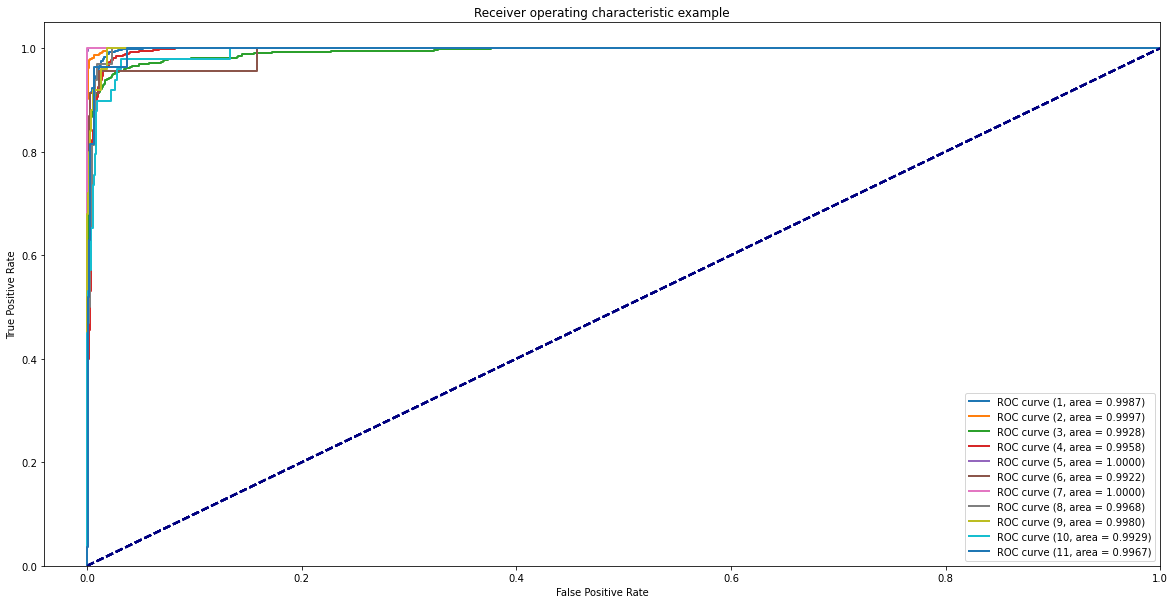

In [14]:
y_test_bin = label_binarize(y_test, classes=list(range(1,13)))
# Compute ROC curve and ROC area for each class
n_classes=12
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba_test.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(20,10))
lw = 2
for i in list(range(1,12)):
    plt.plot(fpr[i], tpr[i],
             lw=lw, label=f'ROC curve ({i}, area = %0.4f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.04, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
plt.show()

Based on the obtained metrics, it is clear that the model is overfitting slightly. Overall, performance is good for the activitiy classes (high 90%), but not for the transition activities (low 80%). Let's investigate the trained model further to understand how we can improve performance.

Feature tBodyGyroJerk-Correlation-3_199: 0, Weight: -0.72162
Feature tBodyAccJerk-Correlation-1_117: 1, Weight: -0.71310
Feature tBodyAcc-Min-3_14: 2, Weight: -0.68270
Feature tGravityAcc-Energy-1_56: 3, Weight: -0.58179
Feature tBodyAcc-Correlation-3_39: 4, Weight: -0.54852
Feature tBodyAcc-ropy-1_23: 5, Weight: -0.50847
Feature tGravityAcc-Min-1_52: 6, Weight: -0.49924
Feature tBodyAcc-Max-2_10: 7, Weight: -0.49421
Feature tGravityAcc-Max-1_49: 8, Weight: -0.49415
Feature tBodyGyroJerk-Correlation-1_197: 9, Weight: -0.46812
Feature tGravityAcc-SMA-1_55: 10, Weight: -0.46667
Feature tBodyAcc-Mean-2_1: 11, Weight: -0.46573
Feature tGravityAcc-Mean-1_40: 12, Weight: -0.45905
Feature tBodyAccJerk-ARCoeff-11_115: 13, Weight: -0.45704
Feature tBodyAccJerk-Correlation-3_119: 14, Weight: -0.45353
Feature tBodyAcc-ropy-1_24: 15, Weight: -0.45082
Feature tBodyGyro-Min-1_132: 16, Weight: -0.45016
Feature fBodyAccJerkMag-MeanFreq-1_525: 17, Weight: -0.41478
Feature tBodyAcc-Max-3_11: 18, Weight:

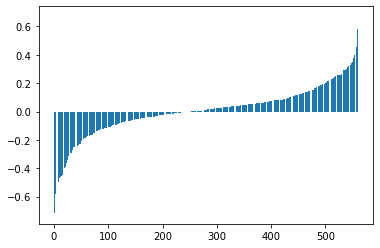

In [15]:
importance = clf.coef_[-1]
# summarize feature importance
importance = list(zip(X_train.columns, importance))
importance.sort(key = lambda x: x[1])
for i,(f, v) in enumerate(importance):
    print('Feature %s: %0d, Weight: %.5f' % (f, i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], [x[1] for x in (importance)])
plt.show()

## Linear Baseline Model with Regularization

While some features only get allocated a small weight, others get allocated weight that are multiple times larger. 
We'll rerun the analysis again, but now using 'LogisticRegressionCV'. This will perform hyperparameter tuning on the regularization coefficient and should reduce overfitting. We'll investigate more advanced techniques in the next notebook.


In [16]:
clf = LogisticRegressionCV(random_state=0, solver='newton-cg').fit(X_train, y_train.values.ravel())
y_pred_train = clf.predict(X_train)
y_pred_proba_train = clf.predict_proba(X_train)

y_pred_test = clf.predict(X_test)
y_pred_proba_test = clf.predict_proba(X_test)

In [20]:
accuracy_score(y_pred_train, y_train), accuracy_score(y_pred_test, y_test)

(0.9945925067593665, 0.946236559139785)

In [21]:
f1_score(y_pred_train, y_train, average='macro'), f1_score(y_pred_test, y_test, average='macro')

(0.9974162018765561, 0.8546135599431076)

Feature tBodyAccJerk-Correlation-1_117: 0, Weight: -1.03209
Feature tBodyGyroJerk-Correlation-3_199: 1, Weight: -1.00620
Feature tBodyAcc-Min-3_14: 2, Weight: -0.93929
Feature tBodyGyroJerk-Correlation-1_197: 3, Weight: -0.75147
Feature tBodyAcc-Correlation-3_39: 4, Weight: -0.73868
Feature tGravityAcc-Energy-1_56: 5, Weight: -0.70292
Feature tBodyGyro-Min-1_132: 6, Weight: -0.67476
Feature tGravityAcc-Max-1_49: 7, Weight: -0.67474
Feature tBodyAcc-Max-2_10: 8, Weight: -0.65625
Feature tBodyAcc-ropy-1_23: 9, Weight: -0.65372
Feature tGravityAcc-SMA-1_55: 10, Weight: -0.64511
Feature tBodyAccJerk-ARCoeff-11_115: 11, Weight: -0.62813
Feature tGravityAcc-Min-1_52: 12, Weight: -0.62542
Feature tBodyAccJerk-Correlation-3_119: 13, Weight: -0.61325
Feature tBodyAcc-Mean-2_1: 14, Weight: -0.60884
Feature tGravityAcc-Mean-1_40: 15, Weight: -0.58136
Feature tBodyAcc-Max-3_11: 16, Weight: -0.56213
Feature tBodyGyroMag-Min-1_243: 17, Weight: -0.55614
Feature fBodyAccJerkMag-MeanFreq-1_525: 18, Wei

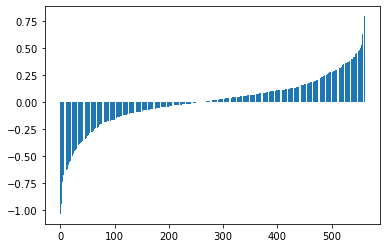

In [19]:
importance = clf.coef_[-1]
# summarize feature importance
importance = list(zip(X_train.columns, importance))
importance.sort(key = lambda x: x[1])
for i,(f, v) in enumerate(importance):
    print('Feature %s: %0d, Weight: %.5f' % (f, i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], [x[1] for x in (importance)])
plt.show()

## Summary

In this notebook, we've setup a simple linear model. The model achieves good performance, but is overfitting quite heavily. Regularization did not significantly improve performance or overfitting. For this reason, we'll be investigating additional techniques in the next notebook. The main metric we'll be using is F1, to ensure we optimize performance towards all classes.